In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Cell 2 – Load & Prepare Dataset
This cell loads the housing dataset, assigns column names, and separates features (X) and target values (y).

In [ ]:

# Column names for Boston Housing dataset
cols = [
    'CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS',
    'RAD','TAX','PTRATIO','B','LSTAT','MEDV'
]

# Load space-separated data
data = pd.read_csv("housing.csv", sep=r"\s+", header=None)
data.columns = cols

# Select features and target
X = data[['RM', 'CRIM']].values
y = data['MEDV'].values.reshape(-1, 1)

# Normalize
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

# Train-test split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


#Cell 3 – Train–Test Split & Normalization

This cell splits the data into training and testing sets and scales the features so that all values are in a similar range

In [10]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def mse(y, y_hat):
    return np.mean((y - y_hat) ** 2)


#Cell 4 – Neural Network Class

This cell defines a neural network from scratch, including forward propagation, backpropagation, and weight update logic using different optimizers.

In [11]:
class NeuralNetwork:
    def __init__(self, lr=0.01, optimizer="gd"):
        self.lr = lr
        self.optimizer = optimizer

        # Weight initialization
        self.W1 = np.random.randn(2, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3) * 0.01
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 1) * 0.01
        self.b3 = np.zeros((1, 1))

        # Optimizer parameters
        self.v = {}
        self.m = {}
        self.t = 0

        for key in ['W1','b1','W2','b2','W3','b3']:
            self.v[key] = np.zeros_like(getattr(self, key))
            self.m[key] = np.zeros_like(getattr(self, key))

    # Forward propagation
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = np.maximum(0, self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = np.maximum(0, self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        return self.Z3

    # Backpropagation
    def backward(self, X, y, y_hat):
        m = len(X)

        dZ3 = (y_hat - y) / m
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * (self.Z2 > 0)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (self.Z1 > 0)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return {
            'W1': dW1, 'b1': db1,
            'W2': dW2, 'b2': db2,
            'W3': dW3, 'b3': db3
        }

    # Weight update step
    def update(self, grads):
        self.t += 1
        beta1, beta2, eps = 0.9, 0.999, 1e-8

        for key in grads:
            if self.optimizer == "gd":
                setattr(self, key,
                        getattr(self, key) - self.lr * grads[key])

            elif self.optimizer == "momentum":
                self.v[key] = beta1 * self.v[key] + self.lr * grads[key]
                setattr(self, key,
                        getattr(self, key) - self.v[key])

            elif self.optimizer == "adam":
                self.m[key] = beta1 * self.m[key] + (1 - beta1) * grads[key]
                self.v[key] = beta2 * self.v[key] + (1 - beta2) * (grads[key] ** 2)

                m_hat = self.m[key] / (1 - beta1 ** self.t)
                v_hat = self.v[key] / (1 - beta2 ** self.t)

                setattr(self, key,
                        getattr(self, key) - self.lr * m_hat / (np.sqrt(v_hat) + eps))


#Cell 5 – Training Function

This cell trains the neural network for multiple epochs and updates weights to minimize prediction error.

In [12]:
def train(model, X, y, epochs=1000):
    losses = []
    for _ in range(epochs):
        y_hat = model.forward(X)
        loss = mse(y, y_hat)
        losses.append(loss)

        grads = model.backward(X, y, y_hat)
        model.update(grads)
    return losses


#Cell 6 – Model Evaluation

This cell tests the trained model on unseen data and calculates the error to check performance

In [13]:
models = {
    "GD": NeuralNetwork(0.01, "gd"),
    "Momentum": NeuralNetwork(0.01, "momentum"),
    "Adam": NeuralNetwork(0.01, "adam")
}

history = {}
for name, model in models.items():
    history[name] = train(model, X_train, y_train)


#Cell 7 – Optimizer Comparison

This cell compares Gradient Descent, Momentum, and Adam by observing loss reduction and convergence speed.

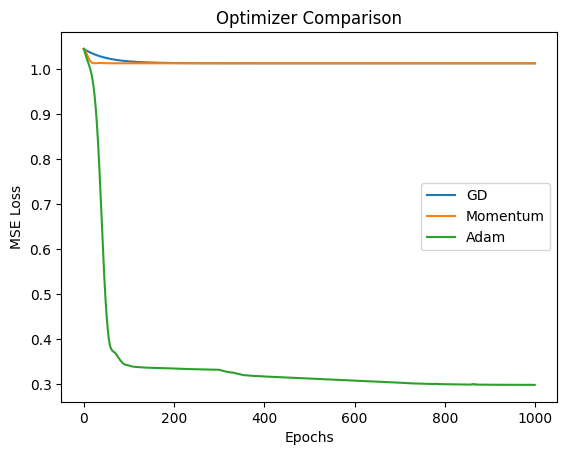

In [14]:
for name, loss in history.items():
    plt.plot(loss, label=name)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Optimizer Comparison")
plt.show()


#Cell 8 – Results & Observations

This cell summarizes which optimizer performs best and explains why based on training behavior.

In [15]:
best_model = models["Adam"]
y_pred = best_model.forward(X_test)

print("Test MSE:", mse(y_test, y_pred))


Test MSE: 0.5852178878324472


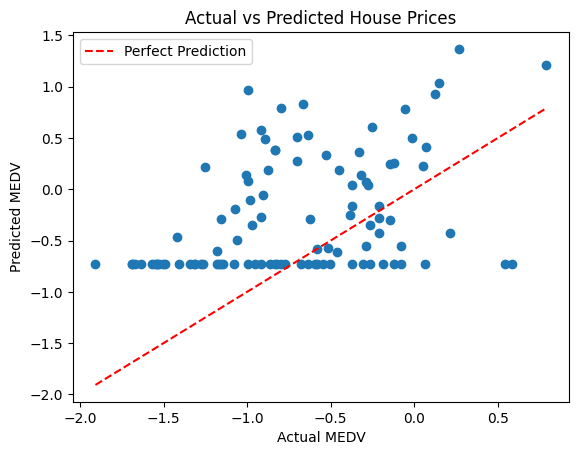

In [17]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.show()
